In [105]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
import pandas as pd
import matplotlib.dates as mdates
import matplotlib.dates as dates
from dateutil.relativedelta import relativedelta
import urllib
import csv
import codecs
import json
from scipy.stats import pearsonr
import datetime

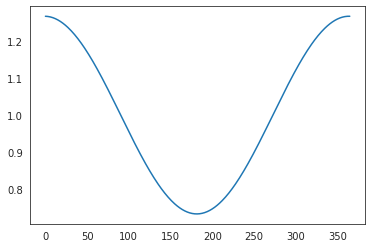

In [2]:
# generate sinusoidal seasonality


def season_multiplier(t, d0=1, gamma=0.267, peak=1) :
    period_fraction = (t - (peak - d0))/365
    
    return 1 + gamma * np.cos(2 * np.pi * period_fraction)


sinus = [season_multiplier(i) for i in range(1,367)]
xs = pd.to_datetime(range(1,366), format='%j') 
xs = [x + relativedelta(years=120) for x in xs]

plt.plot(sinus)

UK sources are all disaggregated by weather station. Would be rigorous...

https://catalogue.ceda.ac.uk/uuid/22f365d2006843c3b95ab89fe3fe0d24

Weird mix of mostly useless EU data

https://cds.climate.copernicus.eu/#!/search?text=ERA5&type=dataset

# Source 1: NASA by central lat/lon

https://power.larc.nasa.gov/data-access-viewer/

https://docs.ropensci.org/nasapower/reference/parameters.html

In [3]:
# #nasaStr = "https://power.larc.nasa.gov/cgi-bin/v1/DataAccess.py?&request=execute&tempAverage=DAILY&identifier=SinglePoint&parameters=T2M&userCommunity=SB&lon=0&lat=0&startDate=20200101&endDate=20201231&outputList=CSV&user=DOCUMENTATION"
# url = "https://power.larc.nasa.gov/cgi-bin/v1/DataAccess.py?"
# params = "T2M_MAX,T2M_MIN,T2M_RANGE"
# lower_left 50.2279, -6.1003 #(lat,lon) 
# upper_right 54.7279, -1.6003 #(lat,lon)

# nasaStr = url + f"&request=execute&tempAverage=DAILY&identifier=Regional&parameters={params}&userCommunity=AG&startDate=20200101&endDate=20201231&bbox=4.7649,-15.6610,9.2649,-11.1610&outputList=JSON&user=DOCUMENTATION"

# res = urllib.request.urlopen(nasaStr)
# cr = csv.reader(codecs.iterdecode(res, 'utf-8'))
# [row for row in cr]
    

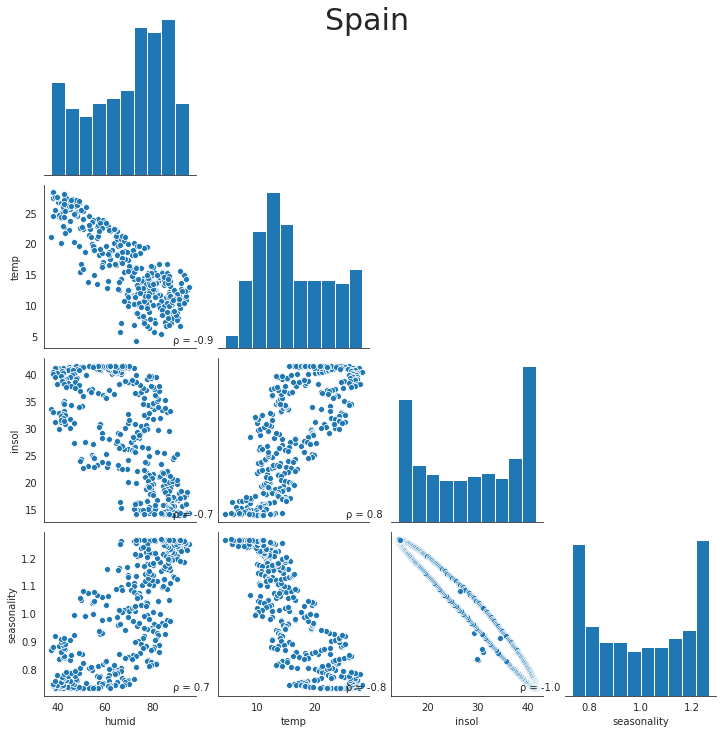

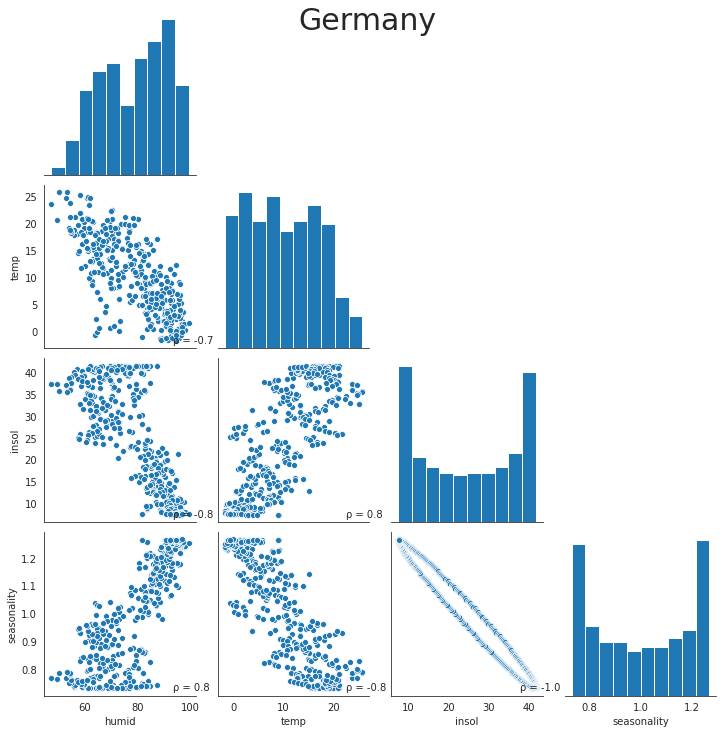

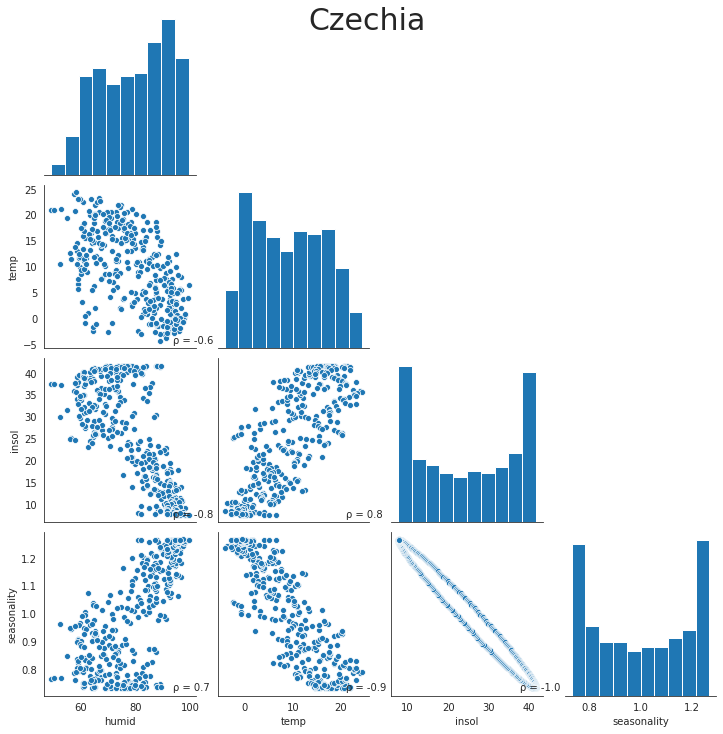

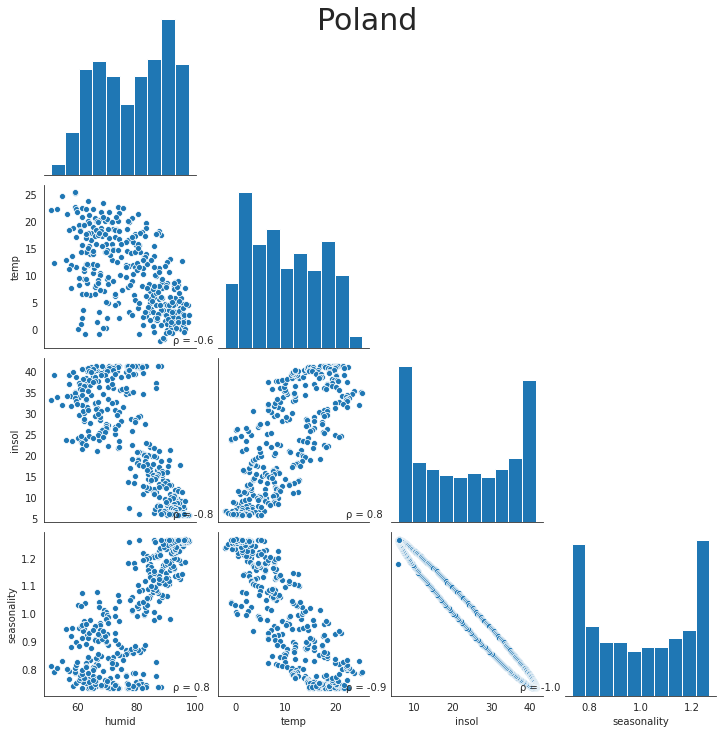

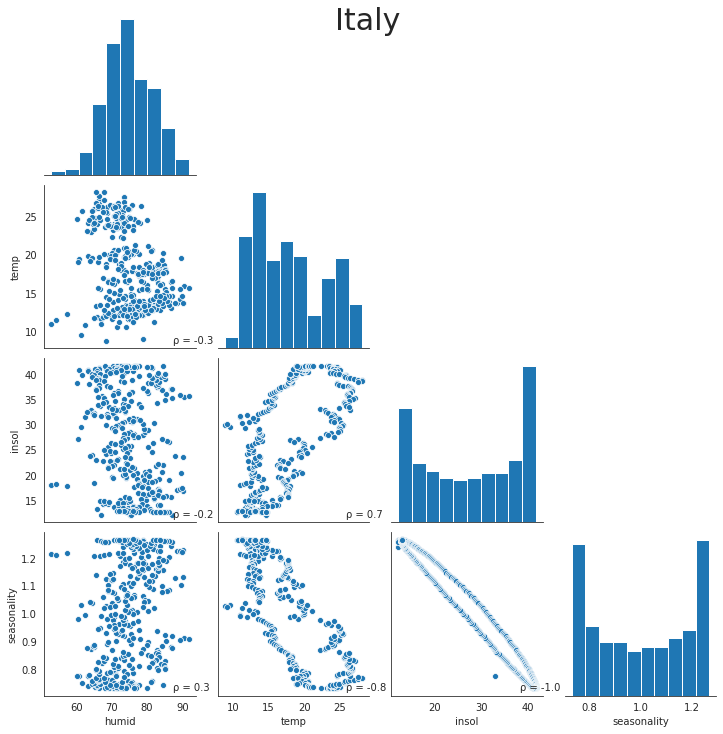

In [77]:
# UK
# lower_left 50.2279, -6.1003 #(lat,lon) 
# upper_right 54.7279, -1.6003 #(lat,lon)

def pairplot_POWER(path, c) :
    cdf = pd.read_csv(path, skiprows=range(13))
    cdf.columns = ["LAT", "LON", "YEAR", "DOY", "humid", "temp", "insol", "infrared"]
    cdf = cdf.drop("infrared", axis=1)
    means = cdf.groupby(["YEAR", "DOY"]).mean()
    means["seasonality"] = sinus
    
    # winsorize
    #means.clip(lower=means.quantile(0.1), upper=means.quantile(0.95), axis=1)
    #means.insol = means.insol.clip(lower=0)
    
    l = means.insol.quantile(0.01)
    u = means.insol.quantile(0.99)
    means.insol = means.insol.clip(lower=l, upper=u)
    
    g = sns.pairplot(means.drop(["LAT", "LON"], axis=1), corner=True)#, plot_kws={'alpha':0.4})
    g.fig.suptitle(c, y=1, fontsize=30)
    g.map_lower(corrfunc)


def corrfunc(x, y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    ax.annotate(f'ρ = {r:.1f}', xy=(.85, .03), xycoords=ax.transAxes)
    
    
# # RH2M Relative Humidity at 2 Meters
# # ALLSKY_TOA_SW_DWN Top-of-atmosphere Insolation #"All Sky Insolation Incident on a Horizontal Surface"

uk = "data/POWER_Regional_Daily_20200101_20201231_e1f88e04_uk.csv"
pairplot_POWER(uk, "UK")

spain = "data/POWER_Regional_Daily_20200101_20201231_3f52643a_es.csv"
pairplot_POWER(spain, "Spain")

de = "data/POWER_Regional_Daily_20200101_20201231_69b95207_de.csv"
pairplot_POWER(de, "Germany")

cz = "data/POWER_Regional_Daily_20200101_20201231_c30935a3_cz.csv"
pairplot_POWER(cz, "Czechia")

pl = "data/POWER_Regional_Daily_20200101_20201231_744d742f_pl.csv"
pairplot_POWER(pl, "Poland")

it = "data/POWER_Regional_Daily_20200101_20201231_e3d574bd_it.csv"
pairplot_POWER(it, "Italy")

# Just our data window

In [94]:
brauner_period = pd.date_range("2020-01-22", "2020-05-30")
sharma_period = pd.date_range("2020-08-01", "2021-01-09")

days = [x.dayofyear for x in brauner_period] + [x.dayofyear for x in sharma_period[:-9]]


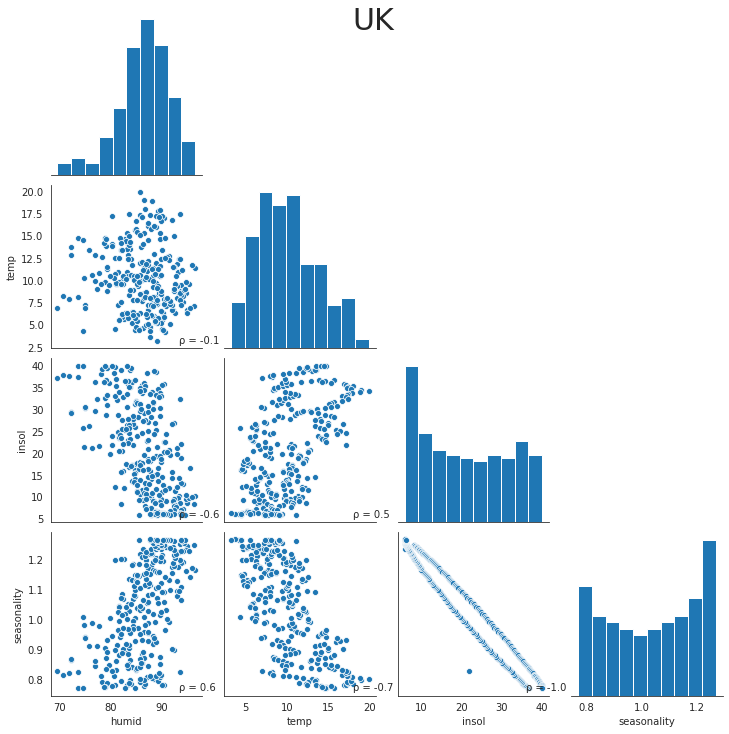

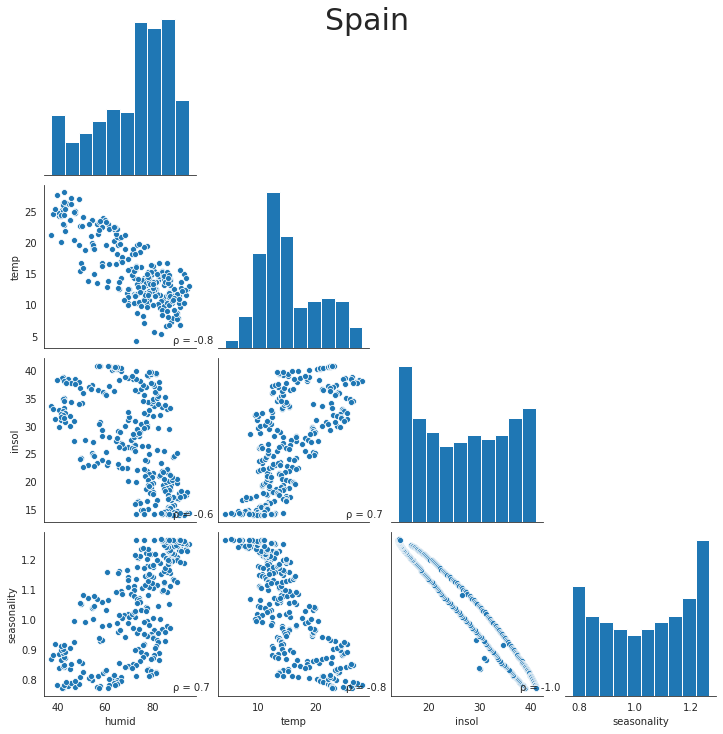

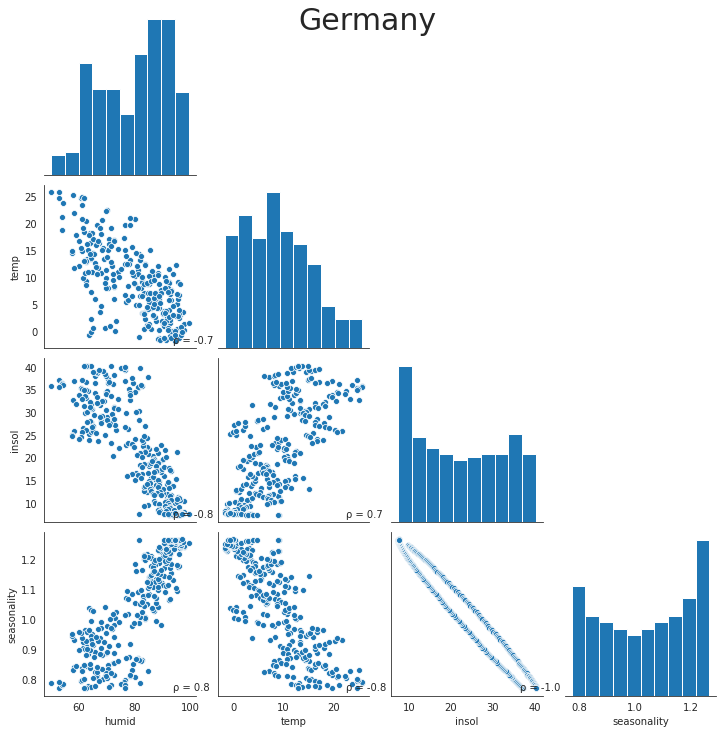

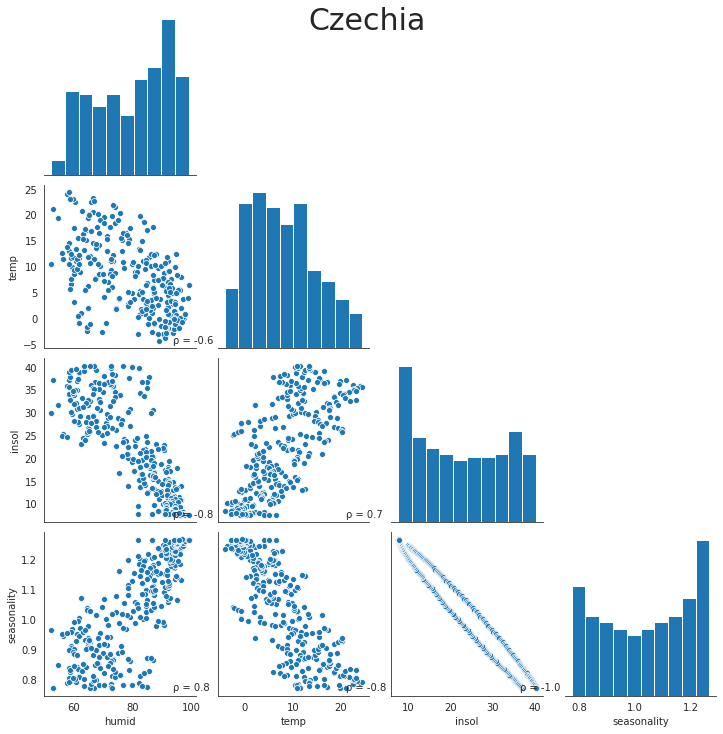

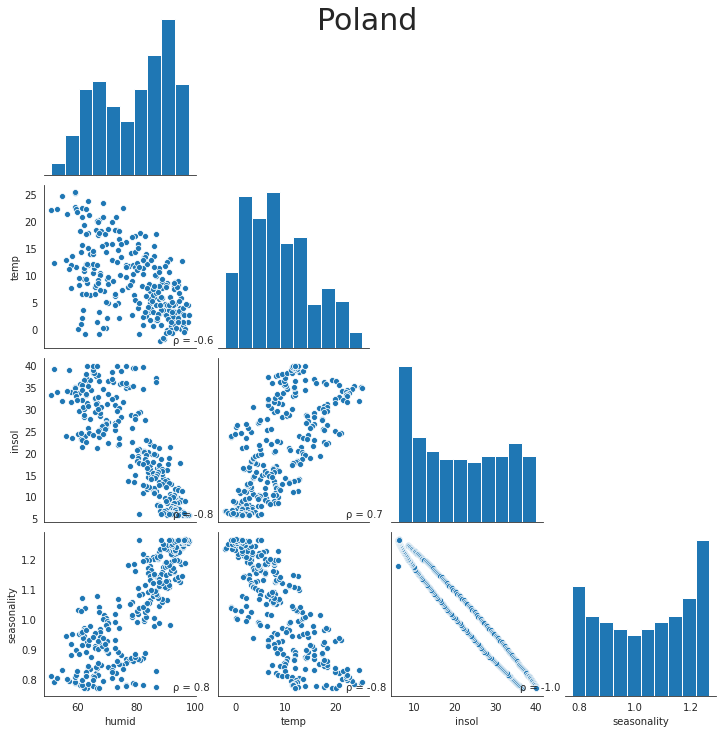

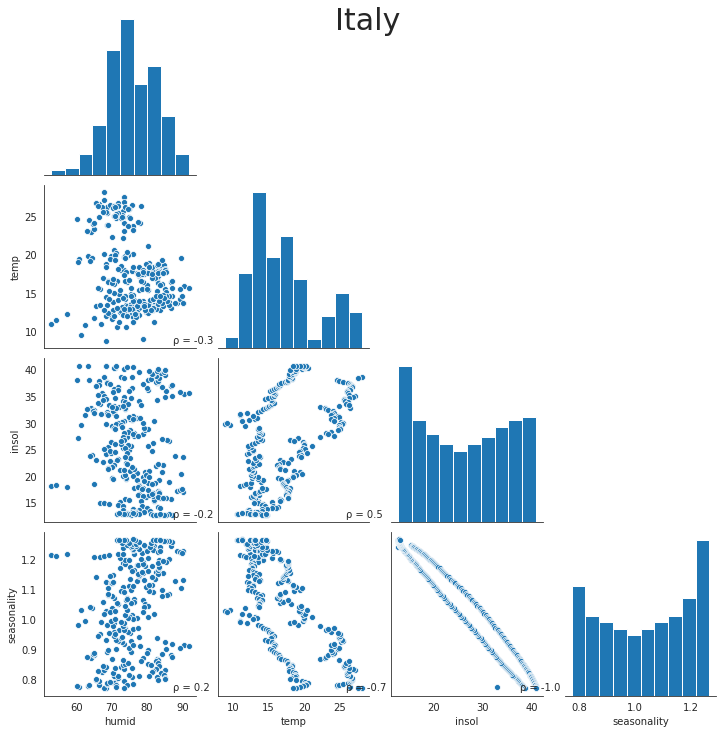

In [98]:
def pairplot_POWER_windowed(path, c) :
    cdf = pd.read_csv(path, skiprows=range(13))
    cdf.columns = ["LAT", "LON", "YEAR", "DOY", "humid", "temp", "insol", "infrared"]
    cdf = cdf.drop("infrared", axis=1)
    cdf = cdf[cdf.DOY.isin(days)]
    means = cdf.groupby(["YEAR", "DOY"]).mean()
    indices = [d-1 for d in days]
    sinus_i = [sinus[i] for i in indices]
    means["seasonality"] = sinus_i
    
    # winsorize
    #means.clip(lower=means.quantile(0.1), upper=means.quantile(0.95), axis=1)
    #means.insol = means.insol.clip(lower=0)
    
    l = means.insol.quantile(0.01)
    u = means.insol.quantile(0.99)
    means.insol = means.insol.clip(lower=l, upper=u)
    
    g = sns.pairplot(means.drop(["LAT", "LON"], axis=1), corner=True)#, plot_kws={'alpha':0.4})
    g.fig.suptitle(c, y=1, fontsize=30)
    g.map_lower(corrfunc)

    
uk = "data/POWER_Regional_Daily_20200101_20201231_e1f88e04_uk.csv"
pairplot_POWER_windowed(uk, "UK")

spain = "data/POWER_Regional_Daily_20200101_20201231_3f52643a_es.csv"
pairplot_POWER_windowed(spain, "Spain")

de = "data/POWER_Regional_Daily_20200101_20201231_69b95207_de.csv"
pairplot_POWER_windowed(de, "Germany")

cz = "data/POWER_Regional_Daily_20200101_20201231_c30935a3_cz.csv"
pairplot_POWER_windowed(cz, "Czechia")

pl = "data/POWER_Regional_Daily_20200101_20201231_744d742f_pl.csv"
pairplot_POWER_windowed(pl, "Poland")

it = "data/POWER_Regional_Daily_20200101_20201231_e3d574bd_it.csv"
pairplot_POWER_windowed(it, "Italy")

## Weekly averages

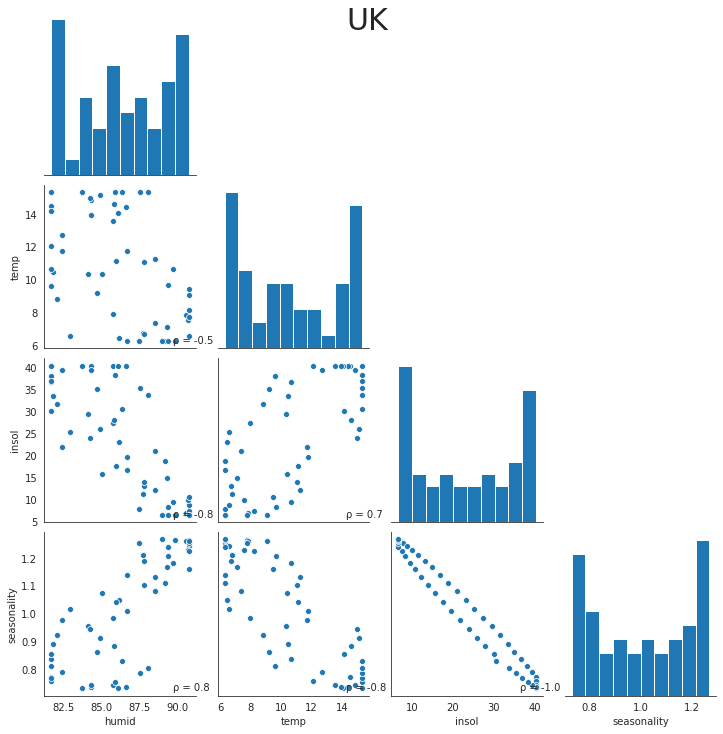

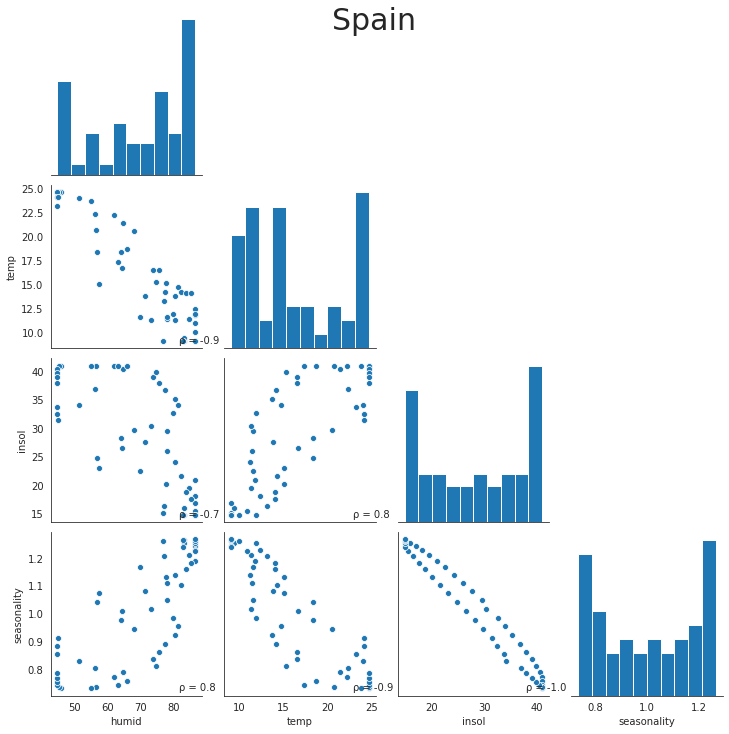

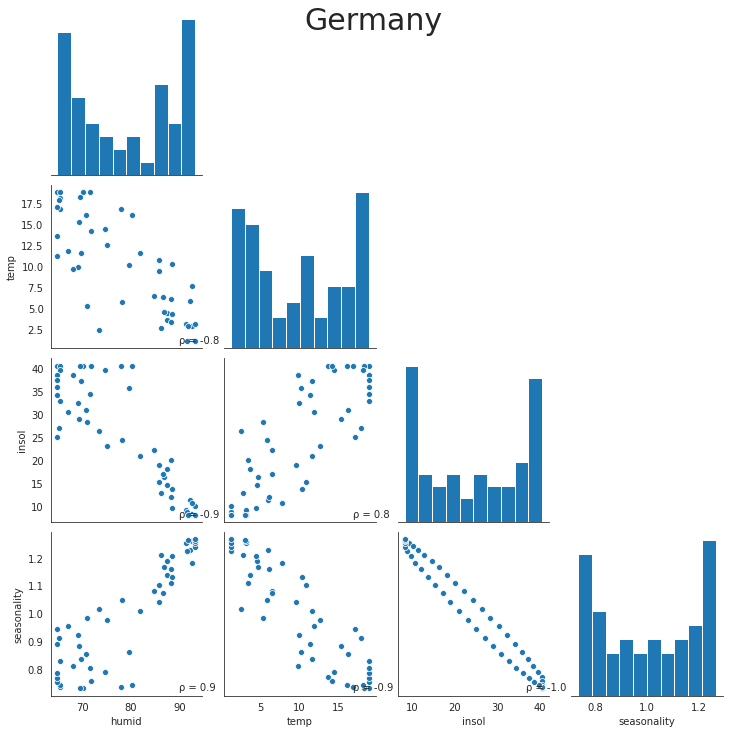

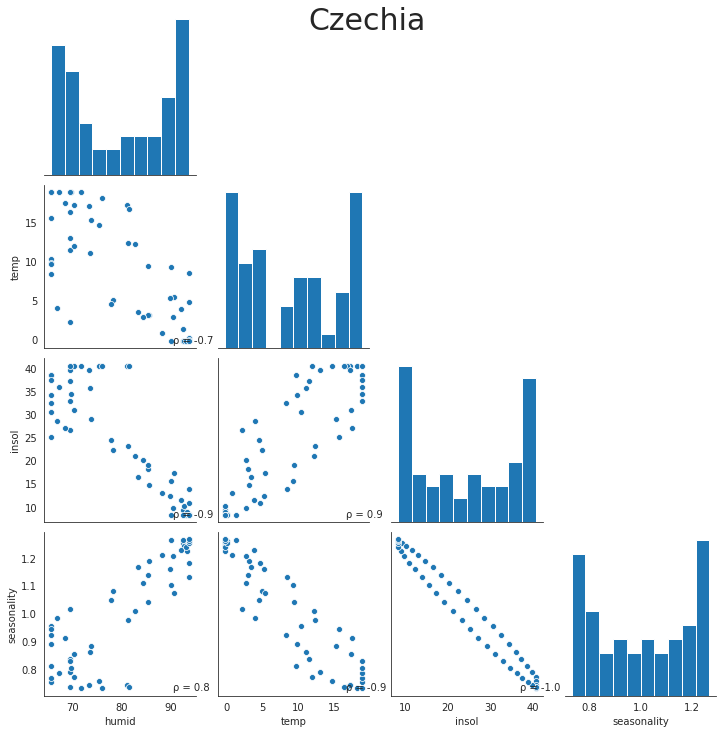

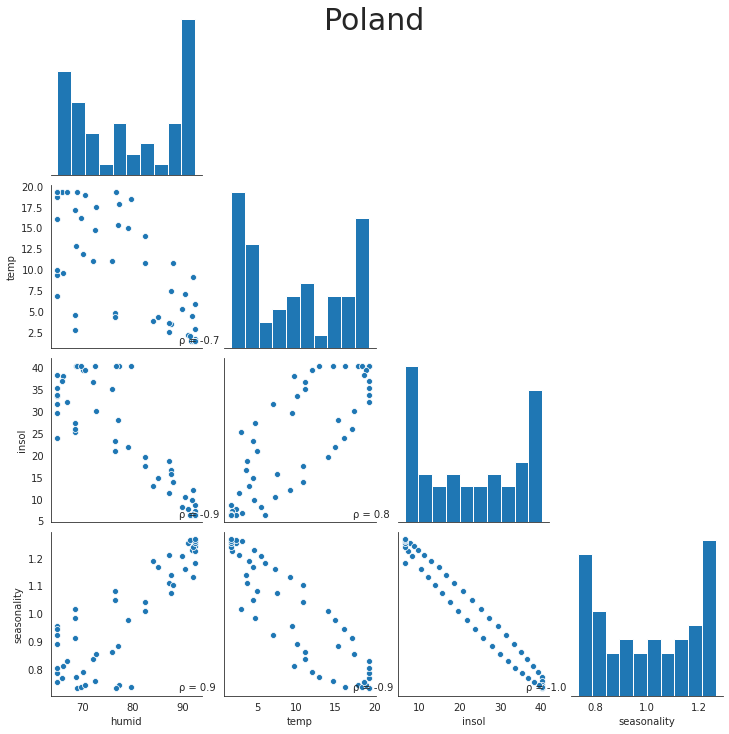

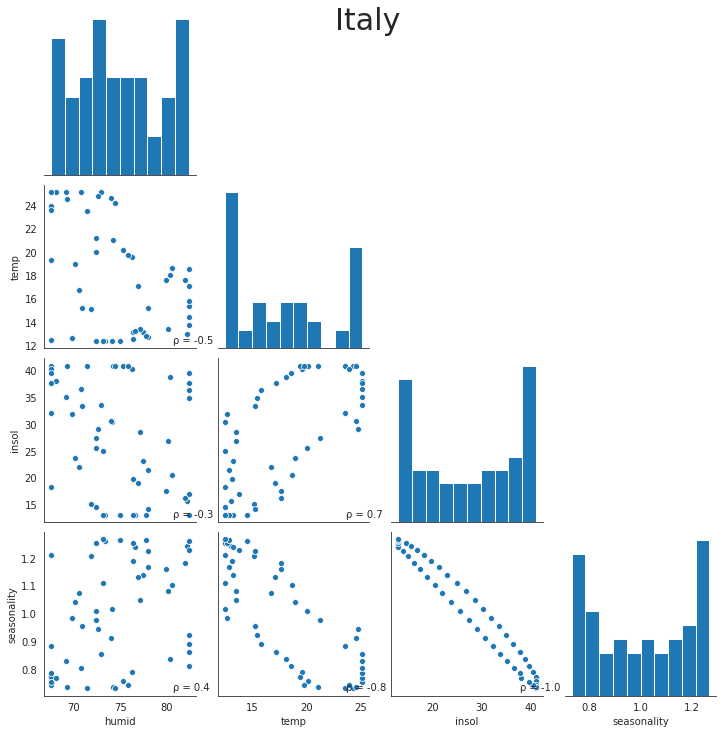

In [141]:
def winsor(means, col) :
    l = means[col].quantile(0.1)
    u = means[col].quantile(0.9)
    means[col] = means[col].clip(lower=l, upper=u)
    
    return means

def pairplot_POWER_rolling(path, c, window_len=1) :
    cdf = pd.read_csv(path, skiprows=range(13))
    cdf.columns = ["LAT", "LON", "YEAR", "DOY", "humid", "temp", "insol", "infrared"]
    cdf = cdf.drop("infrared", axis=1)
    means = cdf.groupby(["YEAR", "DOY"]).mean()
    means["seasonality"] = sinus
    
    rs = means.reset_index()
    
    rs["Date"] = rs["DOY"].apply(lambda row : datetime.datetime(2020, 1, 1) + datetime.timedelta(days=row - 1))
    rs = rs.drop(["YEAR", "DOY"], axis=1)
    rs['Date'] = rs['Date'] - pd.to_timedelta(window_len, unit='d')
    means = rs.groupby(pd.Grouper(key='Date', freq='W-MON')) \
       .mean() \
       .reset_index() \
       .sort_values('Date') 
    
    means = winsor(means, "insol")
    means = winsor(means, "temp")
    means = winsor(means, "humid")
    
    g = sns.pairplot(means.drop(["LAT", "LON"], axis=1), corner=True)#, plot_kws={'alpha':0.4})
    g.fig.suptitle(c, y=1, fontsize=30)
    g.map_lower(corrfunc)
    
    
uk = "data/POWER_Regional_Daily_20200101_20201231_e1f88e04_uk.csv"
pairplot_POWER_rolling(uk, "UK", window_len=7)

spain = "data/POWER_Regional_Daily_20200101_20201231_3f52643a_es.csv"
pairplot_POWER_rolling(spain, "Spain", window_len=7)

de = "data/POWER_Regional_Daily_20200101_20201231_69b95207_de.csv"
pairplot_POWER_rolling(de, "Germany", window_len=7)

cz = "data/POWER_Regional_Daily_20200101_20201231_c30935a3_cz.csv"
pairplot_POWER_rolling(cz, "Czechia", window_len=7)

pl = "data/POWER_Regional_Daily_20200101_20201231_744d742f_pl.csv"
pairplot_POWER_rolling(pl, "Poland", window_len=7)

it = "data/POWER_Regional_Daily_20200101_20201231_e3d574bd_it.csv"
pairplot_POWER_rolling(it, "Italy", window_len=7)

## Monthly averages

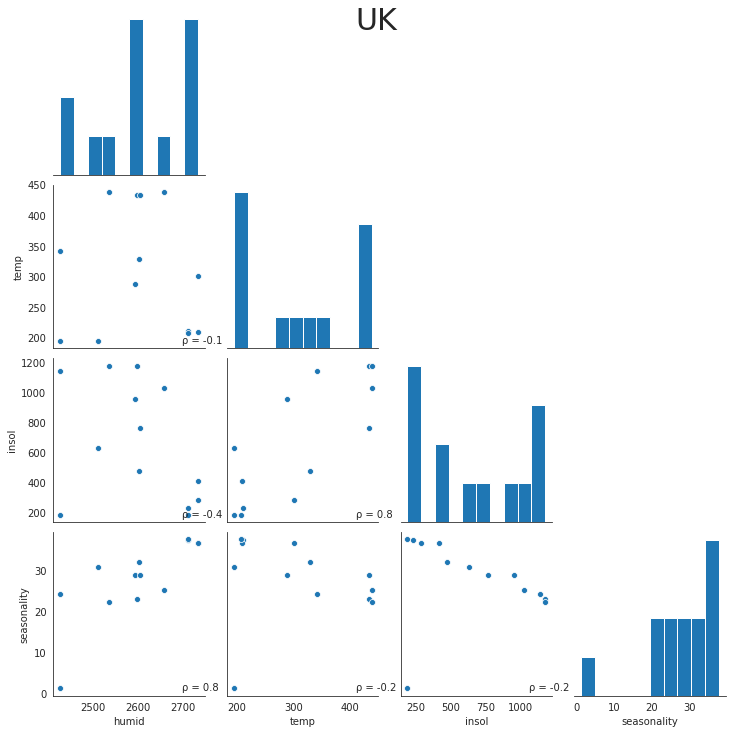

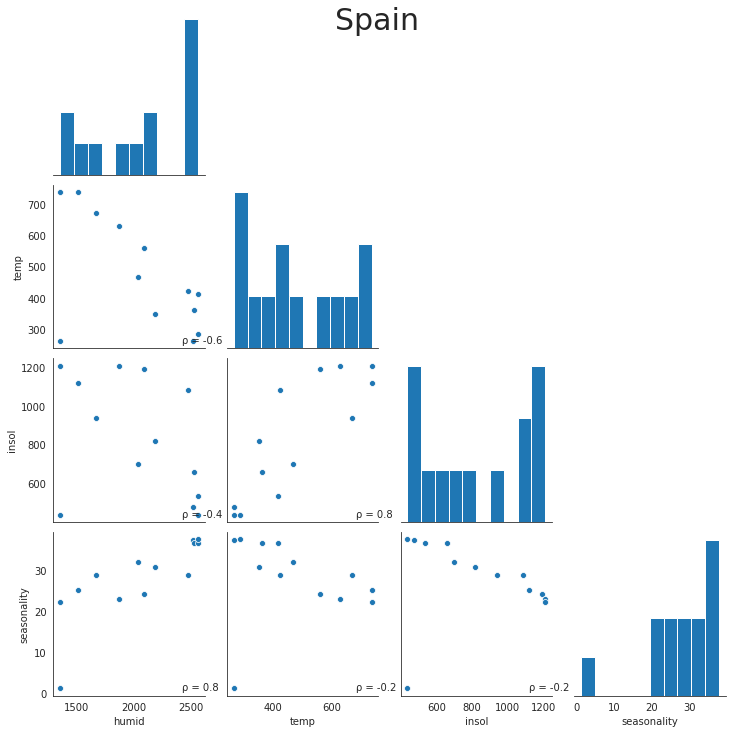

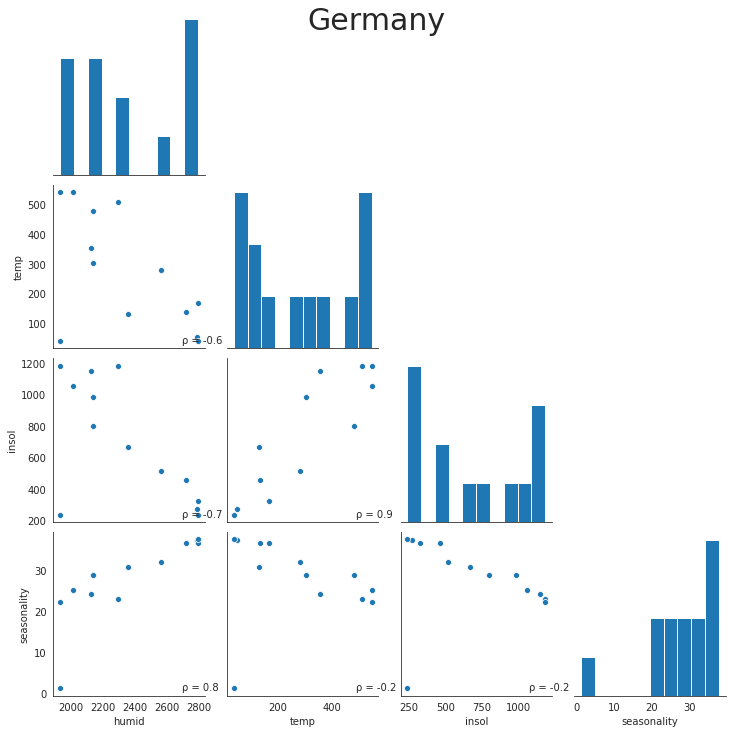

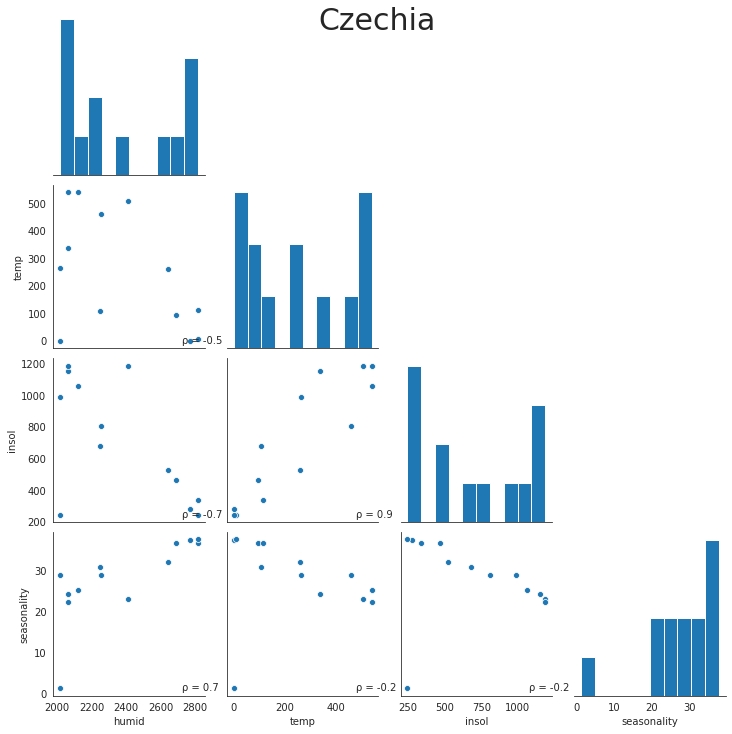

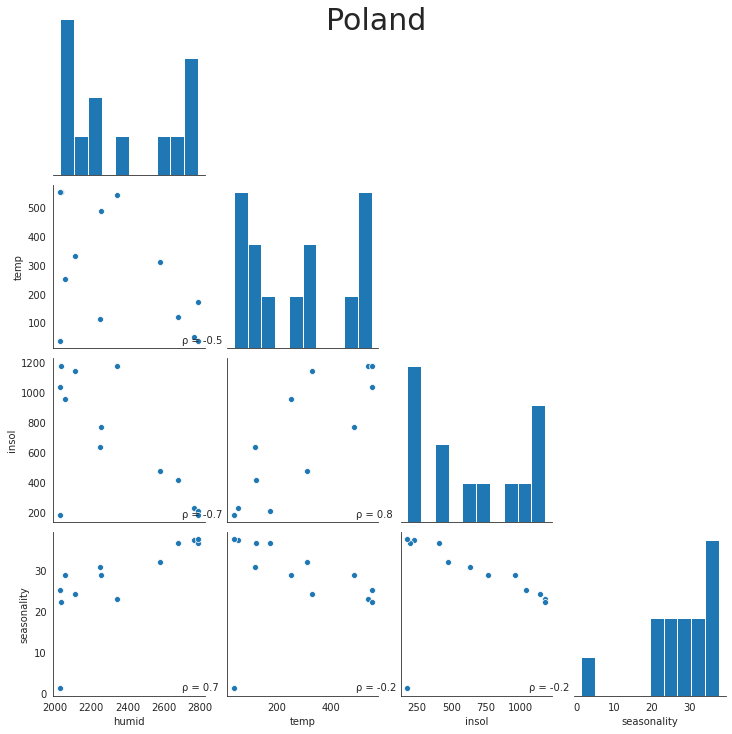

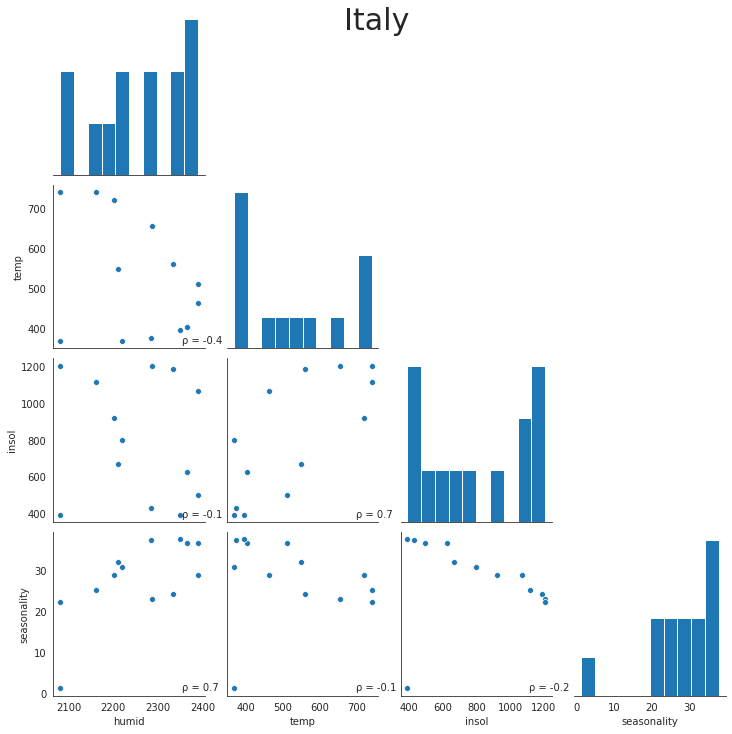

In [140]:
def pairplot_POWER_month(path, c, window_len=1) :
    cdf = pd.read_csv(path, skiprows=range(13))
    cdf.columns = ["LAT", "LON", "YEAR", "DOY", "humid", "temp", "insol", "infrared"]
    cdf = cdf.drop("infrared", axis=1)
    means = cdf.groupby(["YEAR", "DOY"]).mean()
    means["seasonality"] = sinus
    
    rs = means.reset_index()
    
    rs["Date"] = rs["DOY"].apply(lambda row : datetime.datetime(2020, 1, 1) + datetime.timedelta(days=row - 1))
    rs = rs.drop(["YEAR", "DOY"], axis=1)
    #rs['Date'] = rs['Date'] - pd.to_timedelta(window_len, unit='d')
    means = rs.groupby(pd.Grouper(key='Date', freq='M')) \
       .mean() \
       .reset_index() \
       .sort_values('Date') 
    
    means = winsor(means, "insol")
    means = winsor(means, "temp")
    means = winsor(means, "humid")
    
    g = sns.pairplot(means.drop(["LAT", "LON"], axis=1), corner=True)#, plot_kws={'alpha':0.4})
    g.fig.suptitle(c, y=1, fontsize=30)
    g.map_lower(corrfunc)
    
    
uk = "data/POWER_Regional_Daily_20200101_20201231_e1f88e04_uk.csv"
pairplot_POWER_month(uk, "UK", window_len=30)

spain = "data/POWER_Regional_Daily_20200101_20201231_3f52643a_es.csv"
pairplot_POWER_month(spain, "Spain", window_len=30)

de = "data/POWER_Regional_Daily_20200101_20201231_69b95207_de.csv"
pairplot_POWER_month(de, "Germany", window_len=30)

cz = "data/POWER_Regional_Daily_20200101_20201231_c30935a3_cz.csv"
pairplot_POWER_month(cz, "Czechia", window_len=30)

pl = "data/POWER_Regional_Daily_20200101_20201231_744d742f_pl.csv"
pairplot_POWER_month(pl, "Poland", window_len=30)

it = "data/POWER_Regional_Daily_20200101_20201231_e3d574bd_it.csv"
pairplot_POWER_month(it, "Italy", window_len=30)

# Weekly averages, by _country_

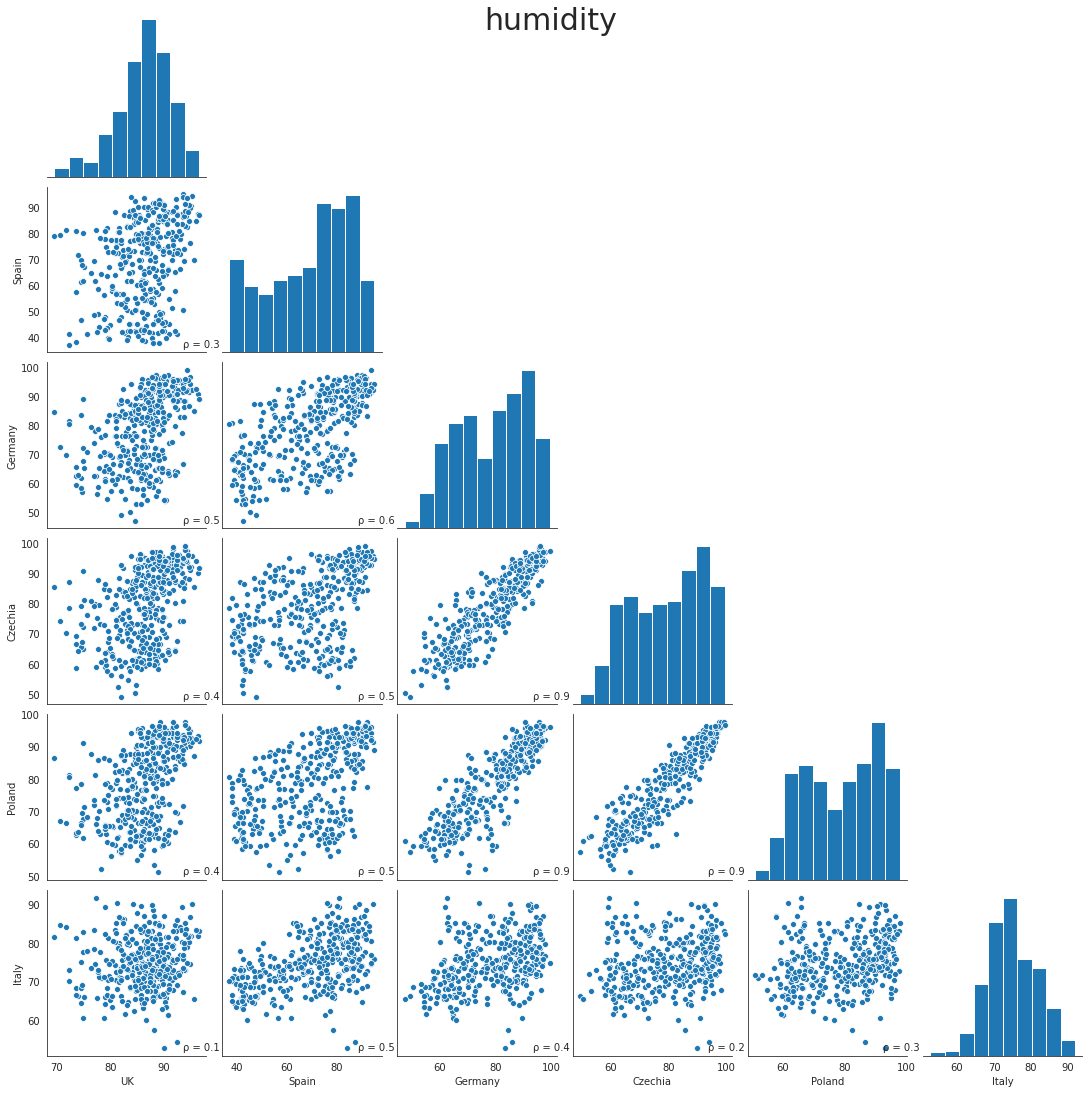

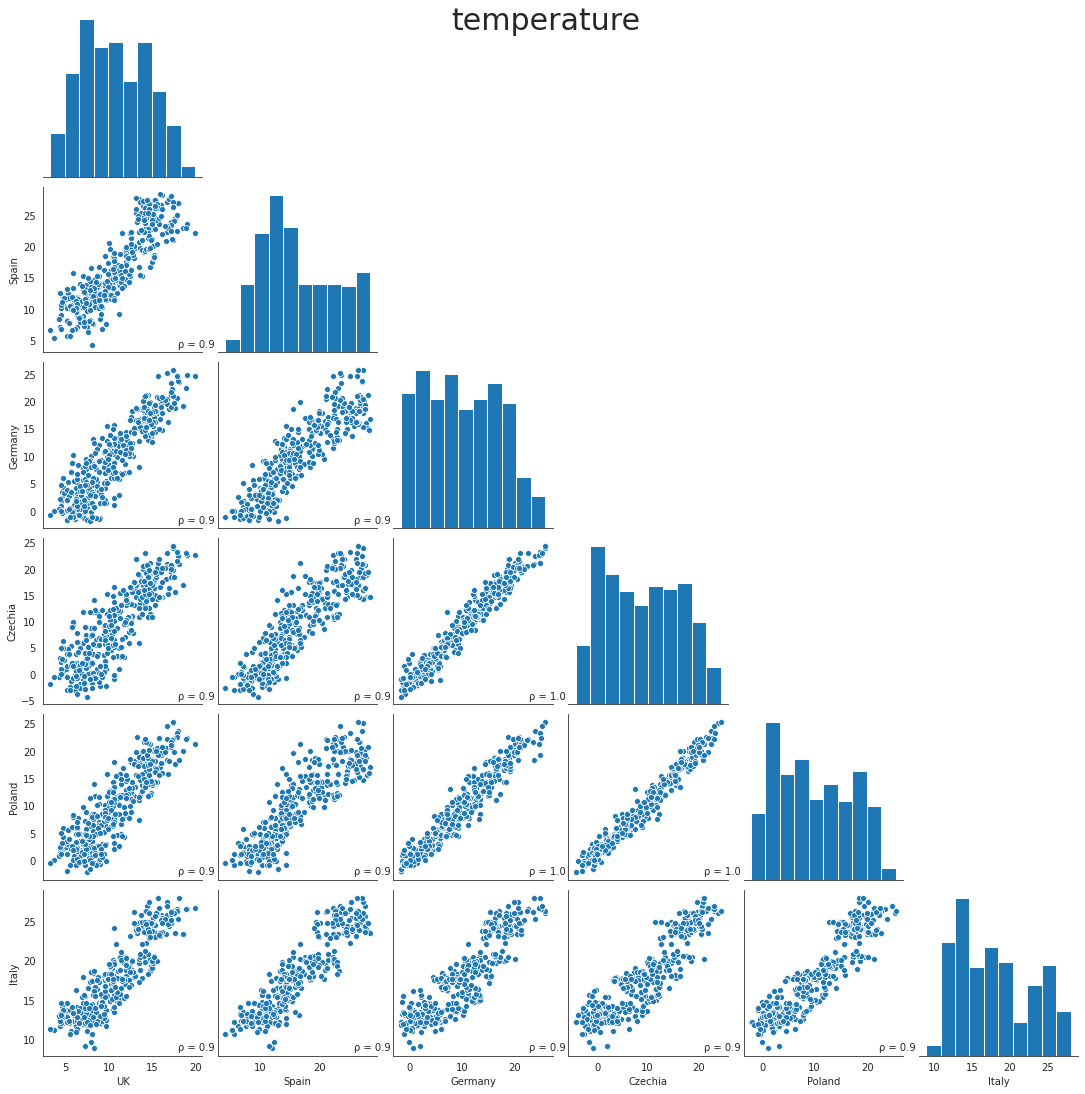

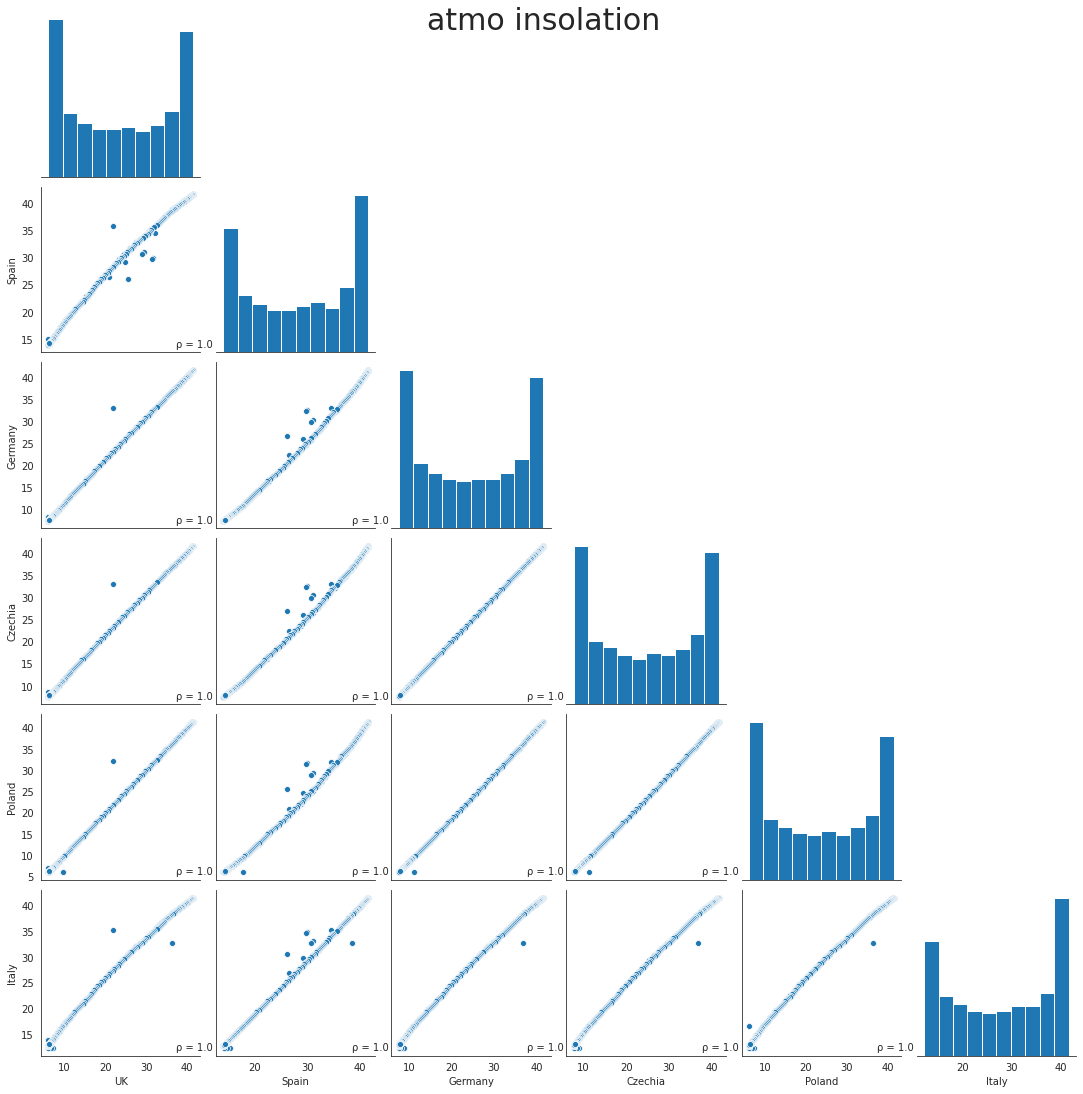

In [208]:
# UK
# lower_left 50.2279, -6.1003 #(lat,lon) 
# upper_right 54.7279, -1.6003 #(lat,lon)

def get_corr_countries(path, c) :
    cdf = pd.read_csv(path, skiprows=range(13))
    cdf.columns = ["LAT", "LON", "YEAR", "DOY", "humid", "temp", "insol", "infrared"]
    cdf = cdf.drop("infrared", axis=1)
    means = cdf.groupby(["YEAR", "DOY"]).mean()
    means["seasonality"] = sinus
    
    # winsorize
    #means.clip(lower=means.quantile(0.1), upper=means.quantile(0.95), axis=1)
    #means.insol = means.insol.clip(lower=0)
    
    l = means.insol.quantile(0.01)
    u = means.insol.quantile(0.99)
    means.insol = means.insol.clip(lower=l, upper=u)
    
    means["country"] = c
    return means
    


def corrfunc(x, y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    ax.annotate(f'ρ = {r:.1f}', xy=(.85, .03), xycoords=ax.transAxes)
    

def plott(means, feature):
    g = sns.pairplot(means, corner=True)
    g.fig.suptitle(feature, y=1, fontsize=30)
    g.map_lower(corrfunc)
    
    
# # RH2M Relative Humidity at 2 Meters
# # ALLSKY_TOA_SW_DWN Top-of-atmosphere Insolation #"All Sky Insolation Incident on a Horizontal Surface"

uk = "data/POWER_Regional_Daily_20200101_20201231_e1f88e04_uk.csv"
uk = get_corr_countries(uk, "UK")

spain = "data/POWER_Regional_Daily_20200101_20201231_3f52643a_es.csv"
spain = get_corr_countries(spain, "Spain")

de = "data/POWER_Regional_Daily_20200101_20201231_69b95207_de.csv"
de = get_corr_countries(de, "Germany")

cz = "data/POWER_Regional_Daily_20200101_20201231_c30935a3_cz.csv"
cz = get_corr_countries(cz, "Czechia")

pl = "data/POWER_Regional_Daily_20200101_20201231_744d742f_pl.csv"
pl = get_corr_countries(pl, "Poland")

it = "data/POWER_Regional_Daily_20200101_20201231_e3d574bd_it.csv"
it = get_corr_countries(it, "Italy")

df = pd.concat([uk, spain, de, cz, pl, it])
df


hum = df[["humid", "country"]].reset_index().drop(["YEAR", "DOY"], axis=1)#.set_index(["country"])#.unstack(level=0)
temp = df[["temp", "country"]].reset_index().drop(["YEAR", "DOY"], axis=1)
insol = df[["insol", "country"]].reset_index().drop(["YEAR", "DOY"], axis=1)



def transpose_melt(df, col) :
    df2 = pd.DataFrame(columns=df.country.unique())
    for country in df.country.unique() :
        df2[country] = df[df.country == country].reset_index()[col]
    
    return df2
    
hum2 = transpose_melt(hum, "humid")
temp2 = transpose_melt(temp, "temp")
insol2 = transpose_melt(insol, "insol")



plott(hum2, "humidity")
plott(temp2, "temperature")
plott(insol2, "atmo insolation")


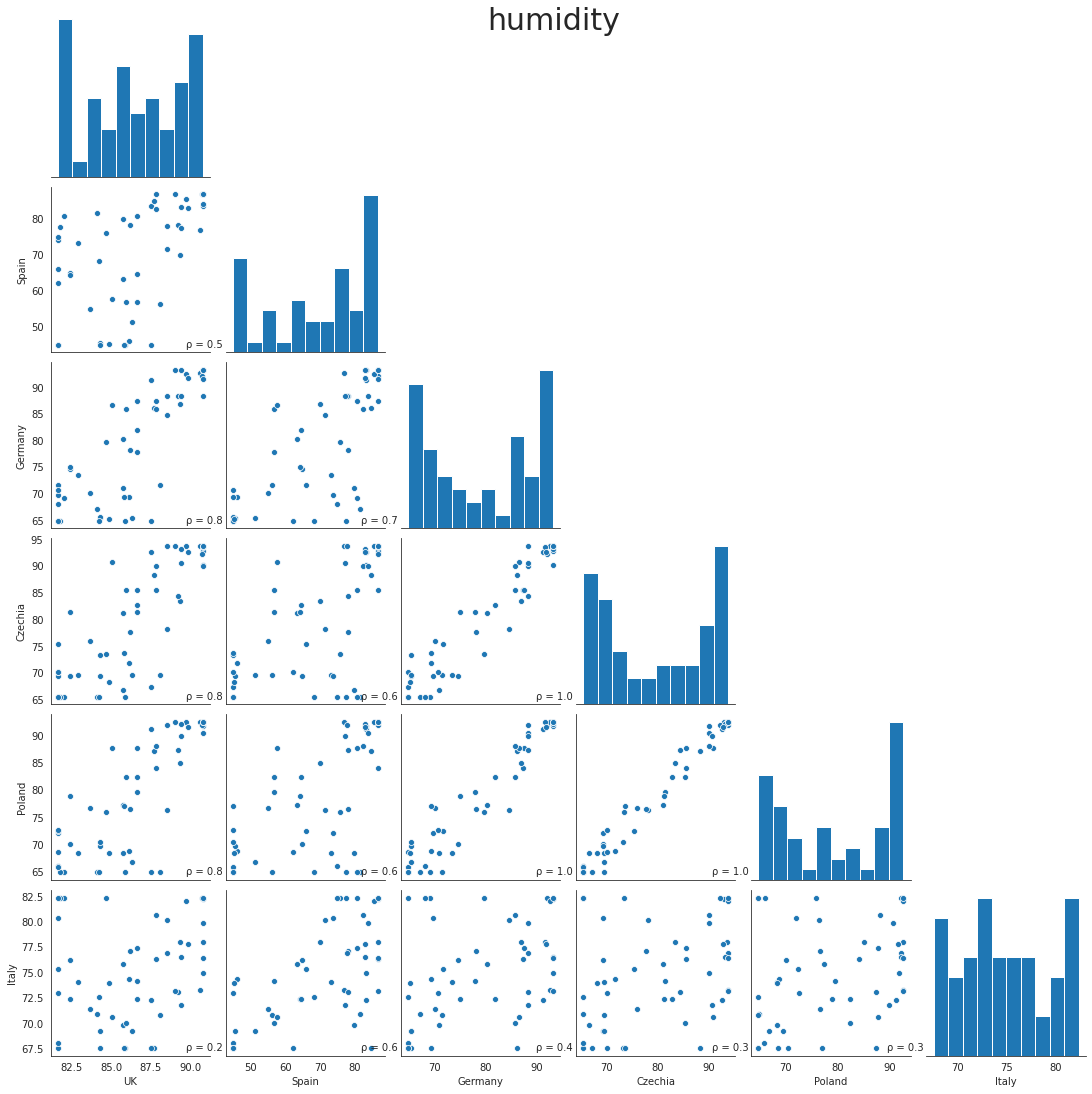

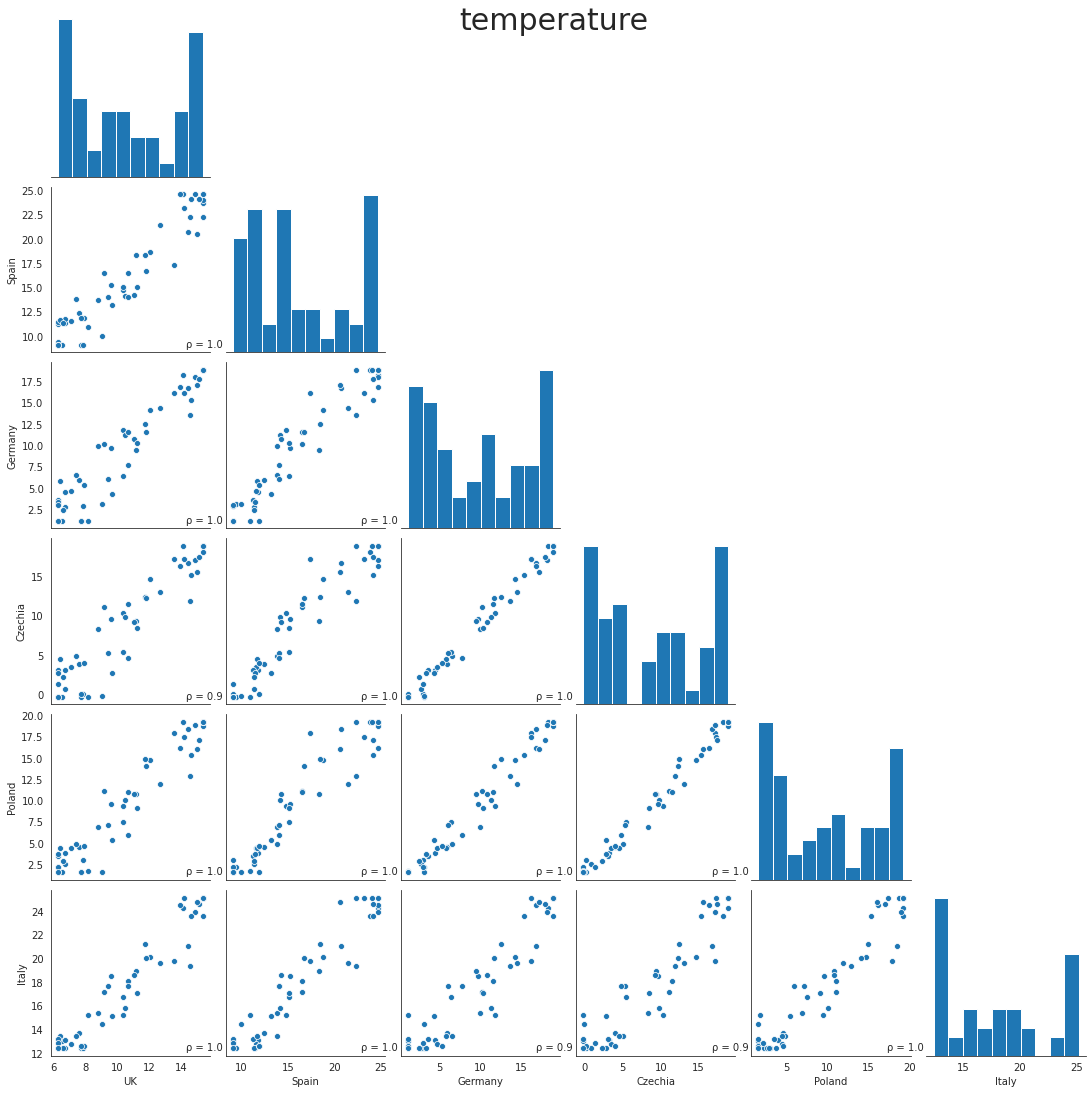

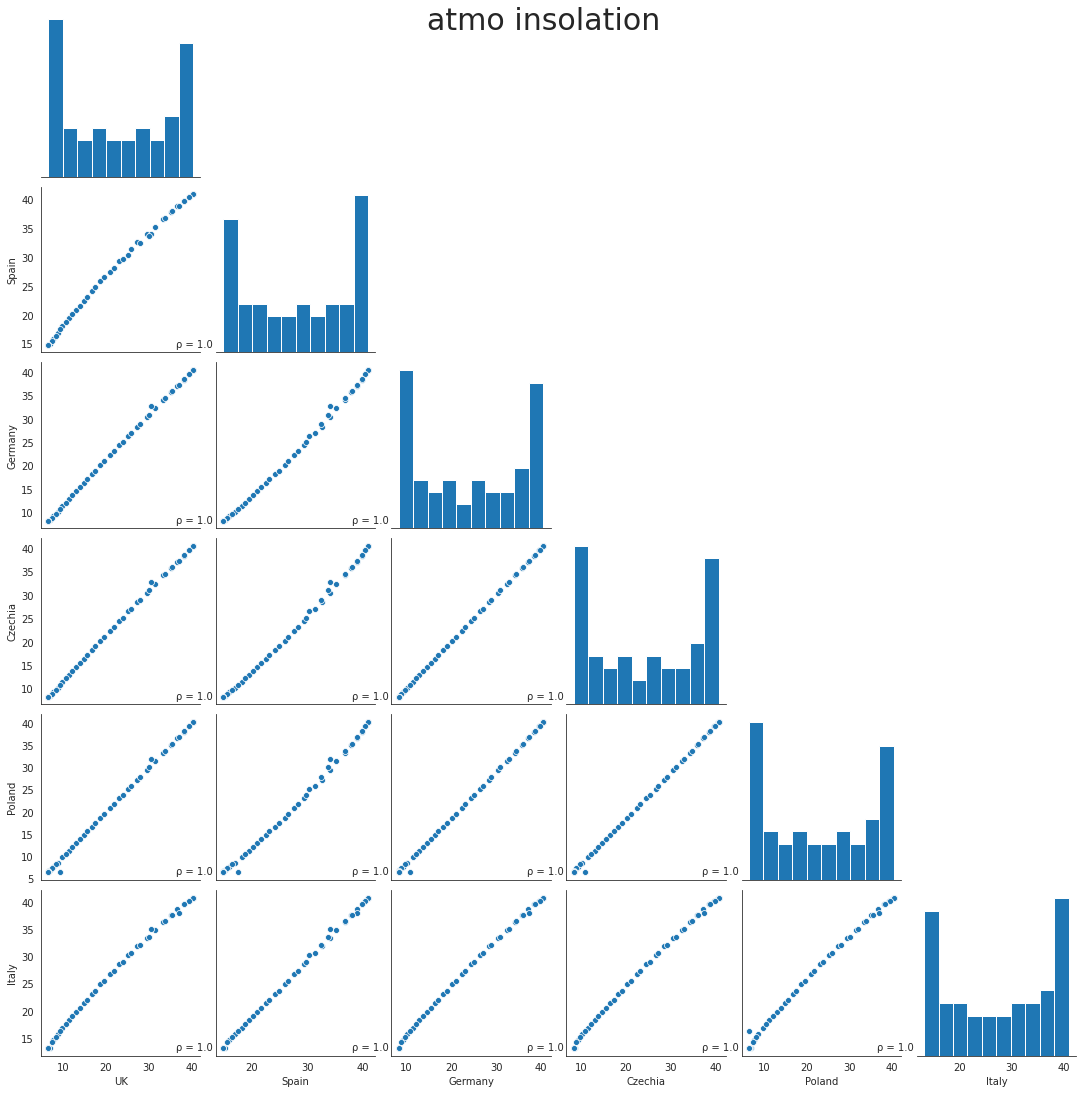

In [209]:
# UK
# lower_left 50.2279, -6.1003 #(lat,lon) 
# upper_right 54.7279, -1.6003 #(lat,lon)

def get_corr_countries(path, c, window_len=7) :
    cdf = pd.read_csv(path, skiprows=range(13))
    cdf.columns = ["LAT", "LON", "YEAR", "DOY", "humid", "temp", "insol", "infrared"]
    cdf = cdf.drop("infrared", axis=1)
    means = cdf.groupby(["YEAR", "DOY"]).mean()
    means["seasonality"] = sinus
    
    rs = means.reset_index()
    
    rs["Date"] = rs["DOY"].apply(lambda row : datetime.datetime(2020, 1, 1) + datetime.timedelta(days=row - 1))
    rs = rs.drop(["YEAR", "DOY"], axis=1)
    rs['Date'] = rs['Date'] - pd.to_timedelta(window_len, unit='d')
    means = rs.groupby(pd.Grouper(key='Date', freq='W-MON')) \
       .mean() \
       .reset_index() \
       .sort_values('Date') 
    
    means = winsor(means, "insol")
    means = winsor(means, "temp")
    means = winsor(means, "humid")
    
    l = means.insol.quantile(0.01)
    u = means.insol.quantile(0.99)
    means.insol = means.insol.clip(lower=l, upper=u)
    
    means["country"] = c
    return means
    


def corrfunc(x, y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    ax.annotate(f'ρ = {r:.1f}', xy=(.85, .03), xycoords=ax.transAxes)
    

def plott(means, feature):
    g = sns.pairplot(means, corner=True)
    g.fig.suptitle(feature, y=1, fontsize=30)
    g.map_lower(corrfunc)
    
    
# # RH2M Relative Humidity at 2 Meters
# # ALLSKY_TOA_SW_DWN Top-of-atmosphere Insolation #"All Sky Insolation Incident on a Horizontal Surface"

uk = "data/POWER_Regional_Daily_20200101_20201231_e1f88e04_uk.csv"
uk = get_corr_countries(uk, "UK")

spain = "data/POWER_Regional_Daily_20200101_20201231_3f52643a_es.csv"
spain = get_corr_countries(spain, "Spain")

de = "data/POWER_Regional_Daily_20200101_20201231_69b95207_de.csv"
de = get_corr_countries(de, "Germany")

cz = "data/POWER_Regional_Daily_20200101_20201231_c30935a3_cz.csv"
cz = get_corr_countries(cz, "Czechia")

pl = "data/POWER_Regional_Daily_20200101_20201231_744d742f_pl.csv"
pl = get_corr_countries(pl, "Poland")

it = "data/POWER_Regional_Daily_20200101_20201231_e3d574bd_it.csv"
it = get_corr_countries(it, "Italy")

df = pd.concat([uk, spain, de, cz, pl, it])
df


hum = df[["humid", "country"]].reset_index()#.set_index(["country"])#.unstack(level=0)
temp = df[["temp", "country"]].reset_index()
insol = df[["insol", "country"]].reset_index()



def transpose_melt(df, col) :
    df2 = pd.DataFrame(columns=df.country.unique())
    for country in df.country.unique() :
        df2[country] = df[df.country == country].reset_index()[col]
    
    return df2
    
hum2 = transpose_melt(hum, "humid")
temp2 = transpose_melt(temp, "temp")
insol2 = transpose_melt(insol, "insol")



plott(hum2, "humidity")
plott(temp2, "temperature")
plott(insol2, "atmo insolation")
